# CNN – XAGUSD Silver

Template for your ML in Finance exam.

In [22]:

TIMEFRAME_MIN = 5         
HORIZON_MIN = 25         

STEPS_AHEAD = HORIZON_MIN // TIMEFRAME_MIN   


USE_MULTI_TARGET = True  


ASK_FILE = "BRENTCMDUSD_5 Mins_Ask_2025.04.01_2025.05.31.csv"
BID_FILE = "BRENTCMDUSD_5 Mins_Bid_2025.04.01_2025.05.31.csv"

print("Predicting", HORIZON_MIN, "minutes ahead → shift(-", STEPS_AHEAD, ")")


Predicting 25 minutes ahead → shift(- 5 )


In [23]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

# Load Ask and Bid data
df_Ask = pd.read_csv(ASK_FILE)
df_Bid = pd.read_csv(BID_FILE)

print("Ask shape:", df_Ask.shape)
print("Bid shape:", df_Bid.shape)

# Merge on time
df = df_Bid.merge(df_Ask, on="Time (UTC)", how="outer")

# Rename columns
df.columns = [
    "Local_time",
    "Open_Bid","High_Bid","Low_Bid","Close_Bid","Volume_Bid",
    "Open_Ask","High_Ask","Low_Ask","Close_Ask","Volume_Ask"
]

print("Merged shape:", df.shape)
df.head()


Ask shape: (10794, 6)
Bid shape: (10794, 6)
Merged shape: (10794, 11)


,Local_time,Open_Bid,High_Bid,Low_Bid,Close_Bid,Volume_Bid,Open_Ask,High_Ask,Low_Ask,Close_Ask,Volume_Ask
0,2025.04.01 00:00:00,74.637,74.715,74.595,74.595,0.00835,74.723,74.765,74.645,74.645,0.00993
1,2025.04.01 00:05:00,74.610,74.680,74.610,74.675,0.00385,74.660,74.730,74.660,74.725,0.00400
2,2025.04.01 00:10:00,74.680,74.695,74.630,74.645,0.00354,74.730,74.745,74.680,74.695,0.00338
3,2025.04.01 00:15:00,74.640,74.700,74.640,74.695,0.00320,74.690,74.750,74.690,74.745,0.00407
4,2025.04.01 00:20:00,74.685,74.700,74.680,74.695,0.00094,74.735,74.750,74.730,74.745,0.00085


In [24]:


# Delta features
df["Close_Delta"] = df["Close_Ask"] - df["Close_Bid"]
df["Volume_Delta"] = df["Volume_Ask"] - df["Volume_Bid"]
df["Volume_Delta_abs"] = df["Volume_Delta"].abs()
df["Open_Delta"]  = df["Open_Ask"]  - df["Open_Bid"]
df["High_Delta"]  = df["High_Ask"]  - df["High_Bid"]
df["Low_Delta"]   = df["Low_Ask"]   - df["Low_Bid"]

# Convert time
df["Local_time_T"] = pd.to_datetime(df["Local_time"], utc=True)

# Data used for modelling: drop Ask OHLC + raw Local_time
data = df.drop([
    "Open_Ask","High_Ask","Low_Ask","Close_Ask","Local_time"
], axis=1)

print("Data columns:", data.columns.tolist())
data.head()


Data columns: ['Open_Bid', 'High_Bid', 'Low_Bid', 'Close_Bid', 'Volume_Bid', 'Volume_Ask', 'Close_Delta', 'Volume_Delta', 'Volume_Delta_abs', 'Open_Delta', 'High_Delta', 'Low_Delta', 'Local_time_T']


,Open_Bid,High_Bid,Low_Bid,Close_Bid,Volume_Bid,Volume_Ask,Close_Delta,Volume_Delta,Volume_Delta_abs,Open_Delta,High_Delta,Low_Delta,Local_time_T
0,74.637,74.715,74.595,74.595,0.00835,0.00993,0.05,0.00158,0.00158,0.086,0.05,0.05,2025-04-01 00:00:00+00:00
1,74.610,74.680,74.610,74.675,0.00385,0.00400,0.05,0.00015,0.00015,0.050,0.05,0.05,2025-04-01 00:05:00+00:00
2,74.680,74.695,74.630,74.645,0.00354,0.00338,0.05,-0.00016,0.00016,0.050,0.05,0.05,2025-04-01 00:10:00+00:00
3,74.640,74.700,74.640,74.695,0.00320,0.00407,0.05,0.00087,0.00087,0.050,0.05,0.05,2025-04-01 00:15:00+00:00
4,74.685,74.700,74.680,74.695,0.00094,0.00085,0.05,-0.00009,0.00009,0.050,0.05,0.05,2025-04-01 00:20:00+00:00


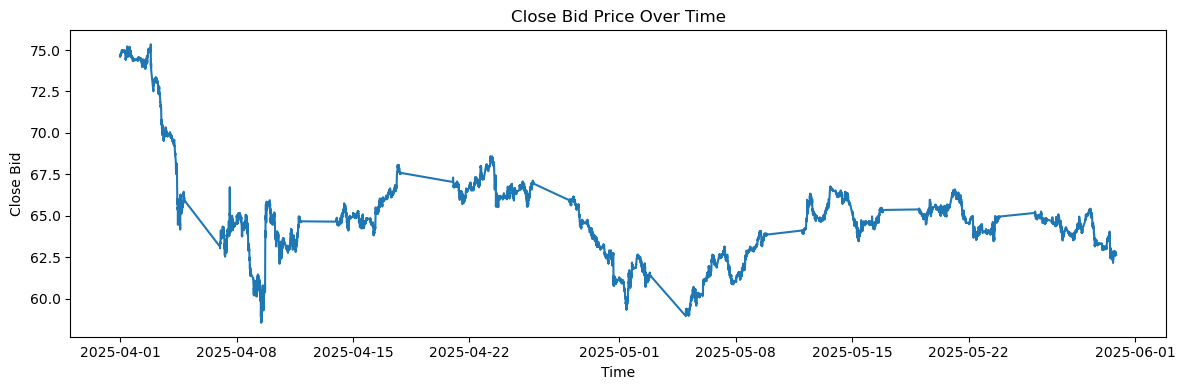

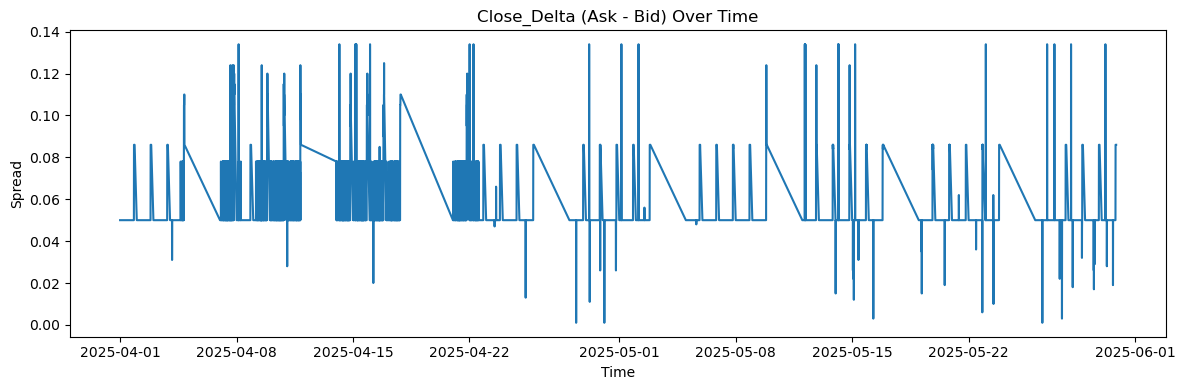

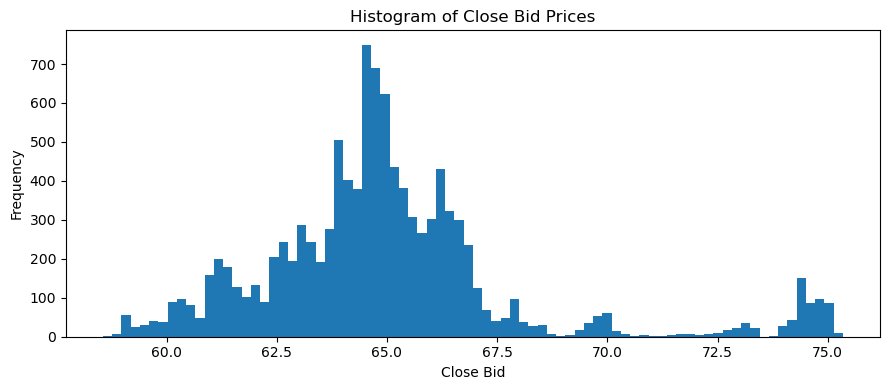

C:\Users\gunti\AppData\Local\Temp\ipykernel_25932\2498177628.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data["Close_Bid"], shade=True)


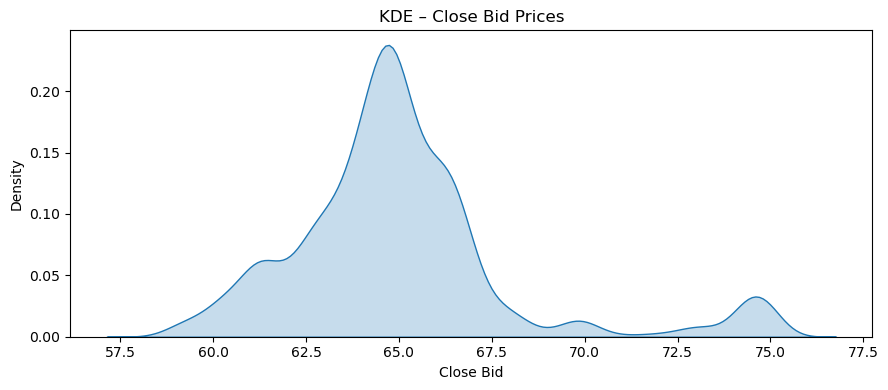

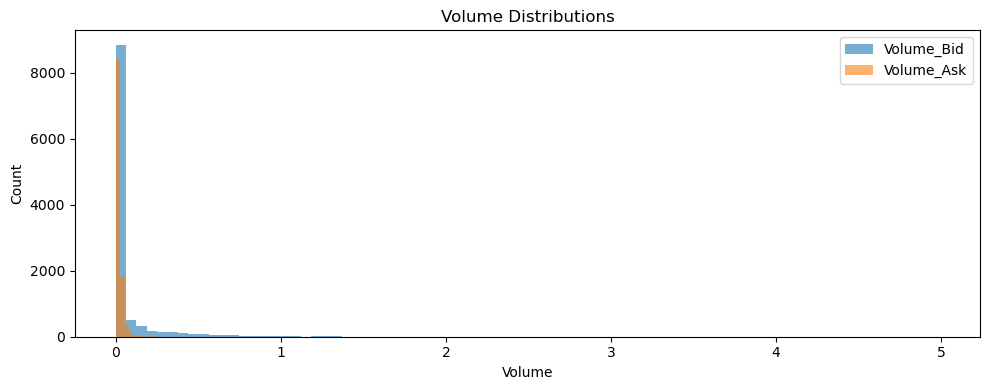

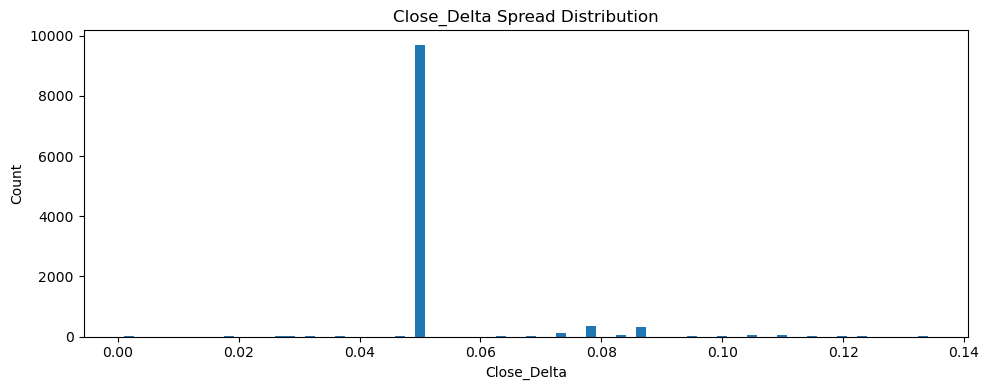

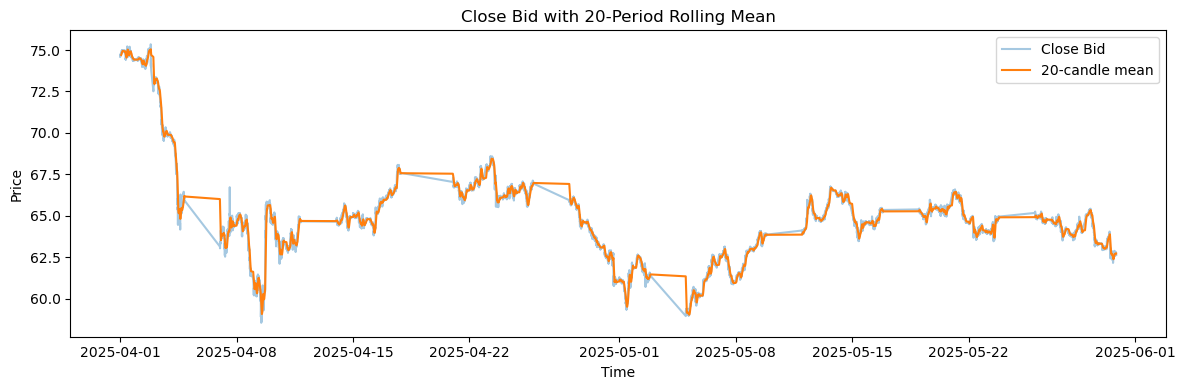

In [25]:

# 1) Close Bid over time
plt.figure(figsize=(12,4))
plt.plot(data["Local_time_T"], data["Close_Bid"])
plt.title("Close Bid Price Over Time")
plt.xlabel("Time")
plt.ylabel("Close Bid")
plt.tight_layout()
plt.show()

# 2) Close_Delta over time (spread)
plt.figure(figsize=(12,4))
plt.plot(data["Local_time_T"], data["Close_Delta"])
plt.title("Close_Delta (Ask - Bid) Over Time")
plt.xlabel("Time")
plt.ylabel("Spread")
plt.tight_layout()
plt.show()

# 3) Histogram of Close_Bid
plt.figure(figsize=(9,4))
plt.hist(data["Close_Bid"], bins=80)
plt.title("Histogram of Close Bid Prices")
plt.xlabel("Close Bid")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# 4) KDE for Close_Bid
plt.figure(figsize=(9,4))
sns.kdeplot(data["Close_Bid"], shade=True)
plt.title("KDE – Close Bid Prices")
plt.xlabel("Close Bid")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

# 5) Volume distributions
plt.figure(figsize=(10,4))
plt.hist(data["Volume_Bid"], bins=80, alpha=0.6, label="Volume_Bid")
plt.hist(data["Volume_Ask"], bins=80, alpha=0.6, label="Volume_Ask")
plt.title("Volume Distributions")
plt.xlabel("Volume")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

# 6) Close_Delta distribution
plt.figure(figsize=(10,4))
plt.hist(data["Close_Delta"], bins=80)
plt.title("Close_Delta Spread Distribution")
plt.xlabel("Close_Delta")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 7) Extra chart – Rolling mean (20 candles)
data["Rolling20"] = data["Close_Bid"].rolling(20).mean()

plt.figure(figsize=(12,4))
plt.plot(data["Local_time_T"], data["Close_Bid"], alpha=0.4, label="Close Bid")
plt.plot(data["Local_time_T"], data["Rolling20"], label="20-candle mean")
plt.title("Close Bid with 20-Period Rolling Mean")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()


In [26]:


df_model = data.copy()


df_model["Y_High_Bid"] = df_model["High_Bid"].shift(-STEPS_AHEAD)


df_model["Y_Low_Ask"]  = (df_model["Low_Bid"] + df_model["Low_Delta"]).shift(-STEPS_AHEAD)


df_model = df_model.dropna().reset_index(drop=True)
print("Rows after shifting:", len(df_model))


feature_cols = [
    "Open_Bid","High_Bid","Low_Bid","Close_Bid",
    "Volume_Bid","Volume_Ask","Close_Delta","Volume_Delta_abs"
]


if USE_MULTI_TARGET:
    target_cols = ["Y_High_Bid","Y_Low_Ask"]
else:
    target_cols = ["Y_High_Bid"]

all_cols = feature_cols + target_cols


train_size = int(len(df_model) * 0.85)
train_df = df_model.iloc[:train_size]

scaler = MinMaxScaler()
scaler.fit(train_df[all_cols])

scaled = scaler.transform(df_model[all_cols])
scaled_df = pd.DataFrame(scaled, columns=all_cols)

dataset = scaled_df.values

X_all = dataset[:, :len(feature_cols)]
Y_all = dataset[:, len(feature_cols):]

print("X_all shape:", X_all.shape)
print("Y_all shape:", Y_all.shape)


Rows after shifting: 10770
X_all shape: (10770, 8)
Y_all shape: (10770, 2)


In [27]:


N = 50  # sequence length

X_seq = []
Y_seq = []

for i in range(len(X_all) - N):
    X_seq.append(X_all[i:i+N])
    Y_seq.append(Y_all[i+N])

X_seq = np.array(X_seq)
Y_seq = np.array(Y_seq)

split_seq = int(len(X_seq) * 0.85)

X_train, X_test = X_seq[:split_seq], X_seq[split_seq:]
Y_train, Y_test = Y_seq[:split_seq], Y_seq[split_seq:]

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("Y_train:", Y_train.shape)
print("Y_test:", Y_test.shape)


X_train: (9112, 50, 8)
X_test: (1608, 50, 8)
Y_train: (9112, 2)
Y_test: (1608, 2)


C:\Users\gunti\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 48, 64)         │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 22, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 704)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        45,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,026 (207.13 KB)

 Trainable params: 53,026 (207.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/13
150/155 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0208 - mae: 0.0947 
Epoch 1: val_loss improved from None to 0.00048, saving model to best_model_LSTM_OIL.keras
155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0104 - mae: 0.0705 - val_loss: 4.7959e-04 - val_mae: 0.0176
Epoch 2/13
149/155 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0058 - mae: 0.0549 
Epoch 2: val_loss did not improve from 0.00048
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0055 - mae: 0.0536 - val_loss: 8.0209e-04 - val_mae: 0.0244
Epoch 3/13
152/155 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0045 - mae: 0.0478 
Epoch 3: val_loss improved from 0.00048 to 0.00036, saving model to best_model_LSTM_OIL.keras
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0043 - mae: 0.0465 - val_loss: 3.5845e-04 - val_mae: 0.0148
Epoch 4/13
152/155 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0040 - mae: 0.0454 
Epoch 4: val_loss improved from 0.00036 to 0.00031, saving model to best_model_LSTM_OIL.keras
155/155 ━━━━

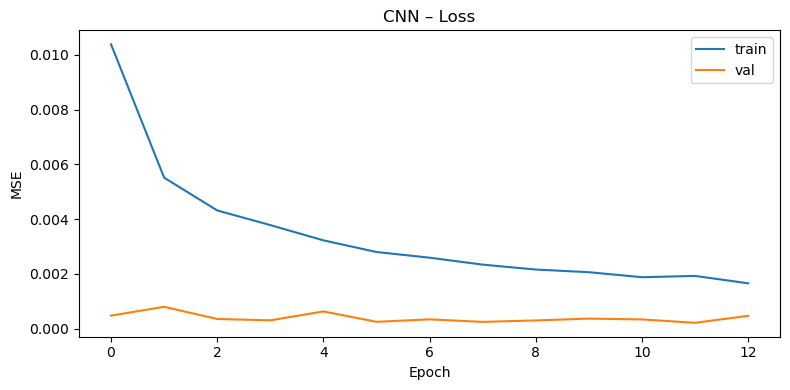

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.6946e-04 - mae: 0.0121 
CNN – Test MSE: 0.00026946287835016847
CNN – Test MAE: 0.012094298377633095
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  


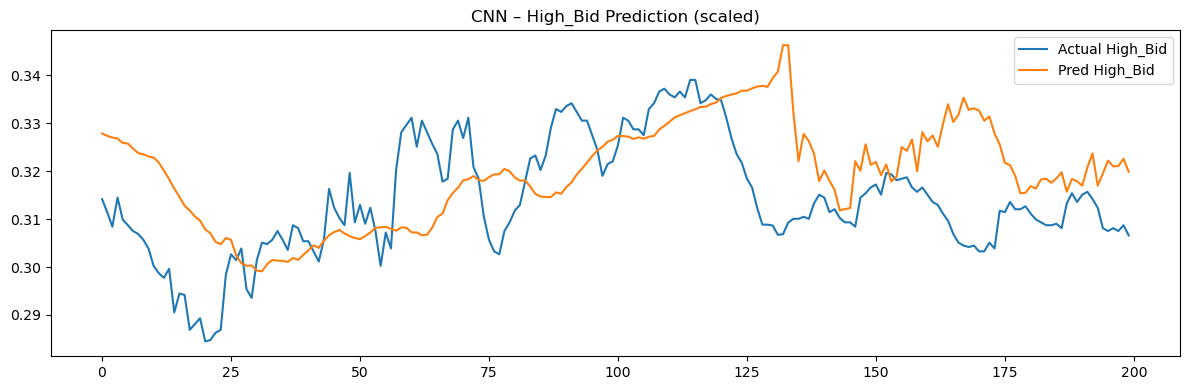

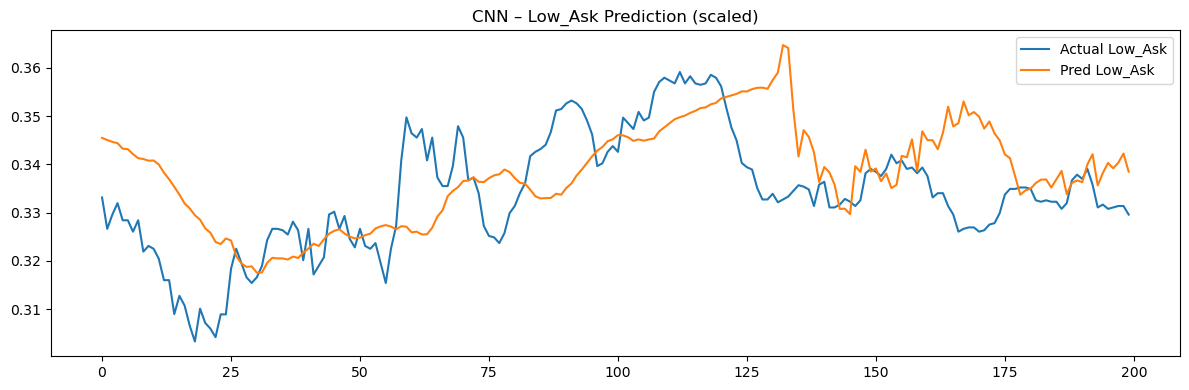

In [29]:


import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dropout

input_timesteps = X_train.shape[1]
input_features = X_train.shape[2]
output_dim = Y_train.shape[1]

cnn_model = models.Sequential()
cnn_model.add(Conv1D(64, kernel_size=3, activation="relu",
                     input_shape=(input_timesteps, input_features)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Conv1D(32, kernel_size=3, activation="relu"))
cnn_model.add(Flatten())
cnn_model.add(layers.Dense(64, activation="relu"))
cnn_model.add(Dropout(0.3))
cnn_model.add(layers.Dense(output_dim))

cnn_model.compile(optimizer="adam", loss="mse", metrics=["mae"])
cnn_model.summary()

early_stop = EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True)
mc = ModelCheckpoint('best_model_LSTM_OIL.keras', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

history = cnn_model.fit(
    X_train, Y_train,
    epochs=13,
    batch_size=50,
    validation_split=0.15,
    callbacks=[early_stop,mc],
    verbose=1
)

plt.figure(figsize=(8,4))
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.title("CNN – Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.tight_layout()
plt.show()

loss, mae = cnn_model.evaluate(X_test, Y_test, verbose=1)
print("CNN – Test MSE:", loss)
print("CNN – Test MAE:", mae)

Y_pred = cnn_model.predict(X_test)

plt.figure(figsize=(12,4))
plt.plot(Y_test[:200,0], label="Actual High_Bid")
plt.plot(Y_pred[:200,0], label="Pred High_Bid")
plt.title("CNN – High_Bid Prediction (scaled)")
plt.legend()
plt.tight_layout()
plt.show()

if Y_test.shape[1] > 1:
    plt.figure(figsize=(12,4))
    plt.plot(Y_test[:200,1], label="Actual Low_Ask")
    plt.plot(Y_pred[:200,1], label="Pred Low_Ask")
    plt.title("CNN – Low_Ask Prediction (scaled)")
    plt.legend()
    plt.tight_layout()
    plt.show()
